<a href="https://colab.research.google.com/github/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex/blob/main/Dynamics_of_representational_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# Representational Geometry in vlPFC
-----------------------------------------------------------------------------
#### This notebook replicates the analysis quantifying the dynamics of representational geometry of neuronal ensembles in the vlPFC in response to the 2560 stimuli with high variation (object pose and size and landscape background)
----
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.
----

In [ ]:
private_link = input('Enter the private link token:')

# Analysis

downloads/Spike_count_odd_sessions.npy already exists.
downloads/Spike_count_even_sessions.npy already exists.
Using 2560 high-variation stimuli, 96 channels, 20 time bins.
Geometry run 1/10 done (pair-unique).
Geometry run 2/10 done (pair-unique).
Geometry run 3/10 done (pair-unique).
Geometry run 4/10 done (pair-unique).
Geometry run 5/10 done (pair-unique).
Geometry run 6/10 done (pair-unique).
Geometry run 7/10 done (pair-unique).
Geometry run 8/10 done (pair-unique).
Geometry run 9/10 done (pair-unique).
Geometry run 10/10 done (pair-unique).
Early–late geometry consistency: obs=0.005496, p_null=0.2687
Saved geometry figure to: Figures/Dynamics_of_representational_geometry_with_null_density.pdf


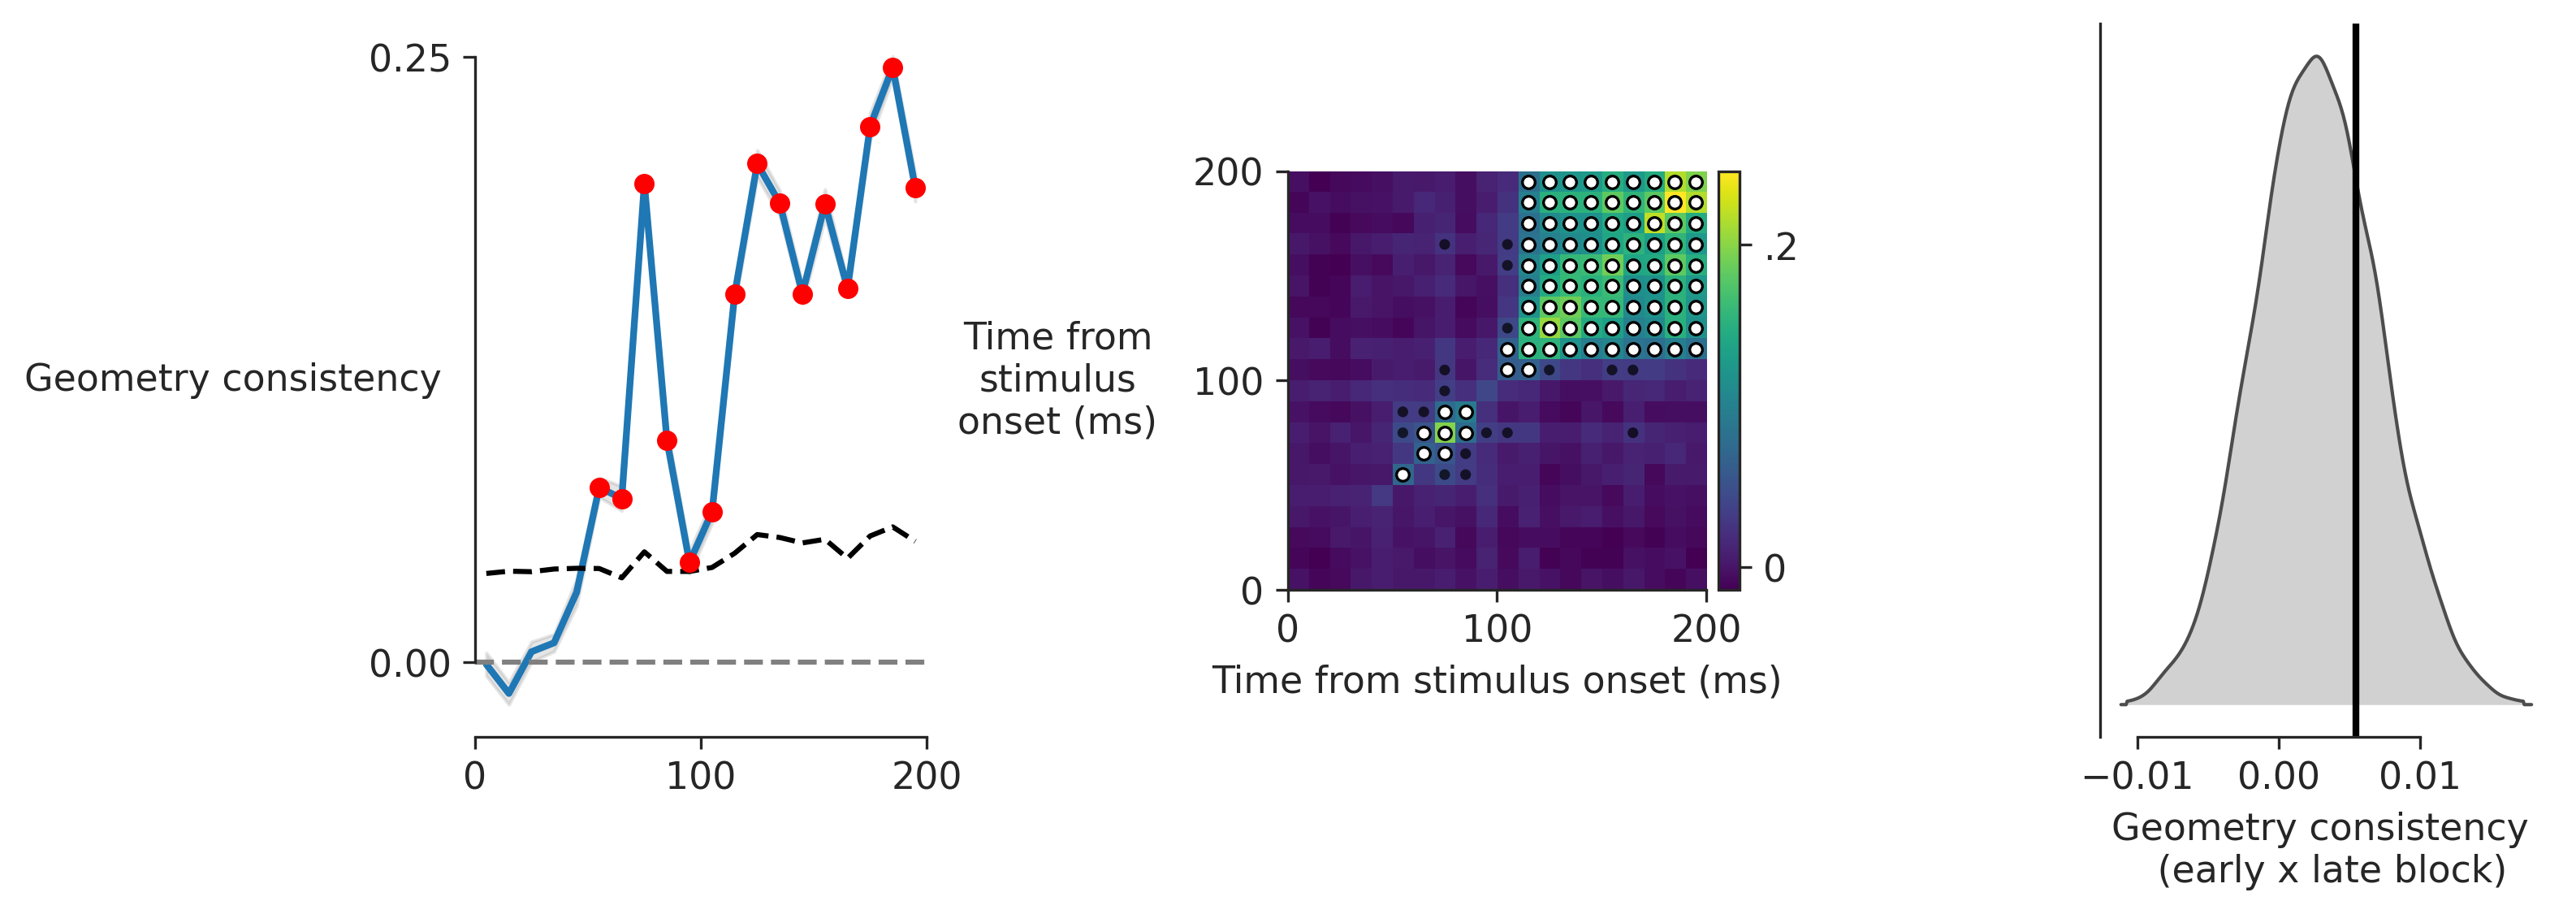

In [19]:
# -*- coding: utf-8 -*-
"""
Representational geometry consistency between odd and even sessions
===================================================================

This script quantifies how consistent the representational geometry
(RDMs) is between odd and even sessions.

For each time bin, we:
  - compute RDMs (pairwise Euclidean distances across stimuli),
  - rank-transform them and correlate odd vs even RDMs (Spearman),
  - use a round-robin, pair-unique scheme with batches and internal
    surrogates to build a null distribution.

Outputs
-------
Figure with 3 horizontal panels:

1) Time course of "Geometry consistency"
   - grand mean across runs
   - grey band: 95% CI (±1.96 · SEM across runs)
   - black dashed: 95% surrogate envelope
   - red dots: FDR-significant time points

2) Cross-temporal "Geometry consistency" matrix
   - imshow of cross-temporal RDM correlation
   - black dots: uncorrected p < .05
   - white dots with black edge: FDR-significant pixels

3) Early–late generalization (pooled)
   - KDE density of the null distribution of early–late geometry consistency
     (50–90 ms rows × 100–200 ms columns)
   - vertical bar = observed early–late geometry consistency

Y-axis and colorbars are labeled "Geometry consistency";
Methods should specify that this is Spearman correlation between
odd- and even-session RDMs.
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ======================================================================================
# 0. Environment & repo path
# ======================================================================================
IN_COLAB = False
IN_KAGGLE = False
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if not IN_COLAB:
    if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
        IN_KAGGLE = True

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Cortex'
else:
    path_to_repo = 'Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    try:
        # In notebooks (Colab/Jupyter)
        get_ipython().system(
            "git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git"
        )
    except Exception:
        # In pure Python script: fall back to subprocess
        import subprocess
        subprocess.run(
            [
                "git",
                "clone",
                "https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git",
            ],
            check=True,
        )

sys.path.append(path_to_repo)

from utils.extract_and_download_data import download_files, unzip  # noqa: E402

# ======================================================================================
# 1. Parameters & data loading
# ======================================================================================
alpha        = 0.05
skip_first   = 640          # Only include high-variation stimuli
batch_size   = 16           # 16 stimuli (8 pairs) per batch
n_runs       = 10           # first 10 round-robin rounds → 10 pair-unique runs
n_surrogates = 2000         # per run for internal permutations

time_course = np.arange(0, 200, 10) + 5   # 20 bins, centers at 5,15,...,195 ms

# Early / late windows for pooled generalization
early_mask = (time_course >= 50) & (time_course <= 90)
late_mask  = (time_course >= 100) & (time_course <= 200)
early_idx  = np.where(early_mask)[0]
late_idx   = np.where(late_mask)[0]

# RNG
rng_global = np.random.default_rng(42)

# ----------------------------------------------------------------------
# Download and load spike data
# ----------------------------------------------------------------------
files_to_download = ['Spike_count_even_sessions.npy', 'Spike_count_odd_sessions.npy']
# Assumes `private_link` exists in your environment
download_files(path_to_repo, files_to_download, private_link=private_link)

even_full = np.load(os.path.join("downloads", "Spike_count_even_sessions.npy"))
odd_full  = np.load(os.path.join("downloads", "Spike_count_odd_sessions.npy"))

# Keep only high-variation stimuli
even = even_full[skip_first:]  # (N_stim, 96, 20)
odd  = odd_full[skip_first:]   # (N_stim, 96, 20)

n_stim, n_chan, T = odd.shape
print(f"Using {n_stim} high-variation stimuli, {n_chan} channels, {T} time bins.")
assert T == len(time_course), "Time dimension mismatch between data and time_course."

# ======================================================================================
# 2. Helper functions
# ======================================================================================
import jax
import jax.numpy as jnp
from scipy.stats import rankdata

def _upper(n):
    iu, ju = np.triu_indices(n, 1)
    return tuple(iu.tolist()), tuple(ju.tolist())

def make_pw_euclid(batch):
    iu, ju = _upper(batch)
    def _pw(X, *, iu=iu, ju=ju):
        iu_a, ju_a = jnp.array(iu), jnp.array(ju)
        diff = X[:, None, :] - X[None, :, :]
        return jnp.sum(diff**2, axis=-1)[iu_a, ju_a]
    return jax.jit(_pw, static_argnames=("iu", "ju"))

def rank_safe(a):
    if a.ndim == 1:
        return rankdata(a)
    return np.vstack([rankdata(a[:, i]) for i in range(a.shape[1])]).T

def batch_rdm(data, idx, pw):
    """
    Compute RDM (pairwise Euclidean distances) for a subset of stimuli.

    data : array (N_stim, n_chan, T)
    idx  : indices of stimuli in this batch
    pw   : JAX-compiled pairwise Euclidean function for this batch size

    Returns: RDM of shape (n_pairs, T), where n_pairs = len(idx)*(len(idx)-1)/2
    """
    X, Tloc = data[idx], data.shape[-1]
    r = np.empty((len(idx)*(len(idx)-1)//2, Tloc), np.float64)
    for t in range(Tloc):
        r[:, t] = np.asarray(pw(jnp.asarray(X[:, :, t])))
    return r

def fdr_triu(p_mat, *, alpha=0.05):
    """
    Run BH-FDR on the upper triangle (including the diagonal) of a square
    p-value matrix and mirror results to full size.
    Returns: sig_mask (bool, same shape as p_mat), q_full (float, same shape)
    """
    iu, ju = np.triu_indices_from(p_mat, k=0)
    pvec   = p_mat[iu, ju]
    reject, qvec, *_ = multipletests(pvec, alpha=alpha, method="fdr_bh")
    sig  = np.zeros_like(p_mat, dtype=bool)
    qmat = np.ones_like(p_mat, dtype=float)
    sig[iu, ju] = reject
    qmat[iu, ju] = qvec
    # mirror to lower triangle
    sig[ju, iu] = sig[iu, ju]
    qmat[ju, iu] = qmat[iu, ju]
    return sig, qmat

def round_robin_pairs(n, rng):
    """
    Round-robin tournament schedule (for n even).
    Returns a list of rounds; each round is a list of (i,j) pairs.
    """
    players = list(range(n))
    rounds = []
    for _ in range(n - 1):
        pairs = [(players[i], players[-i-1]) for i in range(n // 2)]
        rng.shuffle(pairs)
        rounds.append(pairs)
        players = [players[0]] + [players[-1]] + players[1:-1]
    return rounds

def round_to_batches(pairs_round):
    """
    Convert a list of pairs into batches of 8 pairs = 16 stimuli (batch_size).
    """
    pairs_round = list(pairs_round)
    batches = []
    for i in range(0, len(pairs_round), 8):
        chunk = pairs_round[i:i+8]
        flat  = [j for p in chunk for j in p]
        batches.append(np.array(flat, dtype=int))
    return batches

# Single-run RSA functions
def timecourse_once(odd_data, even_data, batches, rng_local):
    """
    Compute 1D time course of RDM correlation for a single run.

    Returns:
        mean_r : (T,)
        surr   : (n_surrogates, T)
    """
    Tloc  = odd_data.shape[-1]
    pw = make_pw_euclid(batch_size)
    real = np.empty((len(batches), Tloc), np.float64)
    diff = np.empty_like(real)

    for g, idx in enumerate(batches):
        idx_p = rng_local.permutation(idx)
        ro, re = (batch_rdm(d, idx,  pw) for d in (odd_data, even_data))
        rop    = batch_rdm(odd_data, idx_p, pw)
        ro, re, rop = map(rank_safe, (ro, re, rop))
        for t in range(Tloc):
            r1 = np.corrcoef(ro[:, t], re[:, t])[0, 1]
            r0 = np.corrcoef(rop[:, t], re[:, t])[0, 1]
            real[g, t] = r1
            diff[g, t] = r1 - r0

    mean_r = real.mean(axis=0)
    surr   = np.empty((n_surrogates, Tloc), np.float64)
    for s in range(n_surrogates):
        surr[s] = (diff * rng_local.choice([-1, 1], size=(len(batches), 1))).mean(axis=0)
    return mean_r, surr

def crosstemp_once(odd_data, even_data, batches, rng_local):
    """
    Compute cross-temporal RDM correlation for a single run.

    Returns:
        mean_ct : (T, T)
        surr    : (n_surrogates, T, T)
    """
    Tloc  = odd_data.shape[-1]
    pw = make_pw_euclid(batch_size)
    actual = np.empty((len(batches), Tloc, Tloc), np.float64)
    null   = np.empty_like(actual)

    for g, idx in enumerate(batches):
        idx_p = rng_local.permutation(idx)
        ro, re = (batch_rdm(d, idx,  pw) for d in (odd_data, even_data))
        rop    = batch_rdm(odd_data, idx_p, pw)
        ro, re, rop = map(rank_safe, (ro, re, rop))
        A  = jnp.hstack([jnp.asarray(ro),  jnp.asarray(re)])
        Ap = jnp.hstack([jnp.asarray(rop), jnp.asarray(re)])
        ca = jnp.corrcoef(A,  rowvar=False)
        cp = jnp.corrcoef(Ap, rowvar=False)
        actual[g] = np.asarray(ca[:Tloc, Tloc:])
        null[g]   = np.asarray(cp[:Tloc, Tloc:])

    mean_ct = actual.mean(axis=0)
    mean_ct = 0.5 * (mean_ct + mean_ct.T)
    surr = np.empty((n_surrogates, Tloc, Tloc), np.float64)
    for s in range(n_surrogates):
        coin   = rng_local.choice([True, False], size=len(batches))
        surr_s = np.mean(np.where(coin[:, None, None], actual, null), axis=0)
        surr[s] = 0.5 * (surr_s + surr_s.T)
    return mean_ct, surr

# ======================================================================================
# 3. RSA Monte-Carlo loop
# ======================================================================================
odd_geom  = odd
even_geom = even
n_stim_geom = odd_geom.shape[0]

pairs_rounds = round_robin_pairs(n_stim_geom, rng_global)
runs_batches = [round_to_batches(pairs_rounds[r]) for r in range(n_runs)]

diag_runs, diag_surr = [], []
ct_runs,   ct_surr   = [], []

for r, batches in enumerate(runs_batches):
    rng_local = np.random.default_rng(rng_global.integers(2**32))
    m_r, s_r   = timecourse_once(odd_geom, even_geom, batches, rng_local)
    m_ct, s_ct = crosstemp_once(odd_geom, even_geom, batches, rng_local)
    diag_runs.append(m_r)
    diag_surr.append(s_r)
    ct_runs.append(m_ct)
    ct_surr.append(s_ct)
    print(f"Geometry run {r+1}/{n_runs} done (pair-unique).")

diag_runs = np.stack(diag_runs)  # (n_runs, T)
ct_runs   = np.stack(ct_runs)    # (n_runs, T, T)

grand_r   = diag_runs.mean(axis=0)
grand_sem = diag_runs.std(axis=0, ddof=1) / np.sqrt(n_runs)
qlo       = grand_r - 1.96 * grand_sem
qhi       = grand_r + 1.96 * grand_sem
grand_ct  = ct_runs.mean(axis=0)

# Surrogates
diag_surr_all = np.concatenate(diag_surr, axis=0)      # (n_runs*n_surrogates, T)
null_hi_diag  = np.percentile(diag_surr_all, 97.5, axis=0)

# Diagonal FDR
p_diag = (diag_surr_all >= grand_r).mean(axis=0)
sig_diag = multipletests(p_diag, alpha=alpha, method="fdr_bh")[0]

# Cross-temporal FDR
ct_surr_all = np.concatenate(ct_surr, axis=0)          # (#surrogates_total, T, T)
p_ct = (ct_surr_all >= grand_ct).mean(axis=0)
sig_ct, q_ct = fdr_triu(p_ct, alpha=alpha)

# ======================================================================================
# 4. Early–late generalization (geometry)
# ======================================================================================
# Observed early–late block per run
EL_runs = np.empty(n_runs, dtype=np.float64)
for r in range(n_runs):
    block = ct_runs[r][np.ix_(early_idx, late_idx)]
    EL_runs[r] = block.mean()

grand_EL = EL_runs.mean()
sem_EL   = EL_runs.std(ddof=1) / np.sqrt(n_runs)

# Surrogate distribution for early–late block
EL_surr = np.empty(ct_surr_all.shape[0], dtype=np.float64)
for k in range(ct_surr_all.shape[0]):
    block_s = ct_surr_all[k][np.ix_(early_idx, late_idx)]
    EL_surr[k] = block_s.mean()

p_EL     = (EL_surr >= grand_EL).mean()
print(f"Early–late geometry consistency: obs={grand_EL:.4g}, p_null={p_EL:.4g}")


# ======================================================================================
# 5. Plot – 3 horizontal panels
# ======================================================================================
plt.rcParams.update({
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11
})
sns.set_style("white")

fig, axes = plt.subplots(
    1, 3, figsize=(11, 3.8),
    gridspec_kw={"wspace": 0.8} # Increased wspace for bigger space between subplots
)
ax1, ax2, ax3 = axes

# ---------- Panel 1: Time-course of geometry consistency ----------
ax1.plot(time_course, grand_r, lw=2, label="Grand mean")

# 95% CI via SEM
ax1.fill_between(
    time_course, qlo, qhi,
    color="grey", alpha=0.2,
    label="95 % CI (±1.96·SEM)"
)

# 95% surrogate envelope
ax1.plot(
time_course, null_hi_diag, "k--", label="95 % surrogate"
)

# FDR-significant time points
ax1.plot(
    time_course[sig_diag],
    grand_r[sig_diag],
    "ro", ms=5,
    label="FDR-significant"
)

ax1.axhline(0, color='gray', linestyle='--') # Add horizontal line at y=0

ax1.set_xlim(0, 200)
ax1.set_xticks([0, 100, 200])
ax1.set_yticks([0, .25])
ax1.tick_params(axis='y', left=True) # Ensure tick marks are visible
ax1.tick_params(axis='x', bottom=True) # Ensure tick marks are visible
ax1.set_ylabel("Geometry consistency", rotation=0,
               labelpad=40, va="center")
sns.despine(ax=ax1, trim=True)
# ---------- Panel 2: Cross-temporal geometry consistency ----------
im = ax2.imshow(
    grand_ct, origin="lower", cmap="viridis",
    extent=[0, 200, 0, 200], interpolation="none"
)
ax2.set_aspect("equal")
ax2.set_xlim(0, 200)
ax2.set_ylim(0, 200)
ax2.set_xticks([0, 100, 200])
ax2.set_yticks([0, 100, 200])
ax2.tick_params(axis='y', left=True) # Ensure tick marks are visible
ax2.tick_params(axis='x', bottom=True) # Ensure tick marks are visible
ax2.set_xlabel("Time from stimulus onset (ms)")
ax2.set_ylabel("Time from\nstimulus\nonset (ms)",
               rotation=0, labelpad=40, va="center")

# Uncorrected significance (p < .05) – black dots
unc_sig = p_ct < 0.05
unc_y, unc_x = np.where(unc_sig)
ax2.scatter(
    time_course[unc_x],
    time_course[unc_y],
    marker='o', s=10,
    facecolors='black', edgecolors='none',
    alpha=0.7, label='p < .05 (uncorrected)'
)

# FDR-corrected significance – white dots with black edge
sig_y, sig_x = np.where(sig_ct)
ax2.scatter(
    time_course[sig_x],
    time_course[sig_y],
    marker='o', s=14,
    facecolors='white', edgecolors='black',
    linewidth=0.8, label='FDR-significant'
)

sns.despine(ax=ax2, trim=True)
# Color-bar attached to panel 2
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb  = plt.colorbar(im, cax=cax)
cb.set_ticks([0, 0.2]) # Set colorbar ticks to 0 and 0.2
cb.set_ticklabels(['0', '.2']) # Set custom tick labels

# ---------- Panel 3: Density of null early–late consistency ----------
# KDE of EL_surr
kde = gaussian_kde(EL_surr)

comb = EL_surr
lo, hi = np.percentile(comb, [0.1, 99.9])
pad = (hi - lo) * 0.05
xmin = min(lo - pad, grand_EL, 0)
xmax = max(hi + pad, grand_EL, 0)

x_grid = np.linspace(xmin, xmax, 400)
dens = kde(x_grid)

# Optional: zero tiny tails for a cleaner shape
dens[dens < 0.005 * dens.max()] = 0

ax3.fill_between(
    x_grid, 0, dens,
    color="0.8", alpha=0.9, lw=0
)
ax3.plot(x_grid, dens, color="0.3", lw=1)

# Vertical line at observed early–late consistency
ax3.axvline(
    grand_EL, 0, 1,
    color="0.0", lw=2,
    label="Observed"
)

ax3.set_xlabel("Geometry consistency \n (early x late block)")
ax3.set_ylabel("") # Removed "Density" label
ax3.set_yticks([]) # Removed y-axis ticks to hide the associated axis
ax3.tick_params(axis='x', bottom=True) # Ensure tick marks are visible
sns.despine(ax=ax3, trim=True)
# Save figure
os.makedirs("Figures", exist_ok=True)
out_path = os.path.join(
    "Figures",
    "Dynamics_of_representational_geometry_with_null_density.pdf"
)
fig.savefig(out_path, dpi=300, bbox_inches="tight")

print(f"Saved geometry figure to: {out_path}")
